# Model Comparisons
This notebook can be used to compare models agaist each other.

## Preperation
Imports:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gif
from keras.models import load_model
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve, \
    recall_score, roc_auc_score, roc_curve, plot_roc_curve
from math import pi
import ipywidgets as widgets
from ipywidgets import interact, fixed, Layout
import preprocess

Load the models:

In [6]:
model_paths = [
    'models/psp_act-sigmoid_lr-0.001_itr-1.h5',
    'models/psp_act-sigmoid_lr-0.001_itr-2.h5',
    'models/psp_act-softmax_lr-0.001_itr-1.h5',
    'models/psp_act-softmax_lr-0.001_itr-2.h5'
]

model_names = []
for path in model_paths:
    model_names.append(path.split('/')[1].strip('.h5'))

models = []
for model in model_paths:
    models.append(load_model(model))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Prepare the test data:

In [137]:
X_test, y_test = preprocess.labeled_data(
    'practice_images/multi_category/test/raw/', 
    'practice_images/multi_category/test/annot/', 
    resize=(480, 480))

print(f'X_test shape = {X_test.shape}\ny_test shape = {y_test.shape}')

X_test shape = (2, 480, 480, 3)
y_test shape = (2, 480, 480, 5)


Store the class names:

In [6]:
classes = ('background', 'coated surface', 'tape', 'blast surface', 'polished surface')

__Predictions with the models__
* Store list of categorical predictions in `y_preds`
* Combine prediction channels into a single channel `y_preds_combined`.  Note that this is a simple combination method that assigns the class of the pixel to the channel with the highest probability prediction.  More acurate models may be possible if they take different approaches.

In [138]:
y_preds = []
for model in models:
    y_preds.append(model.predict(X_test))


def combine(array):
    rtn_array = np.zeros_like(array[:, :, :, 0])
    for batch, _ in enumerate(array):
        for row, _ in enumerate(array[0]):
            for column, _ in enumerate(array[0, 0]):
                rtn_array[batch, row, column] = array[batch, row, column, :].argmax()
    return rtn_array


def combine_advanced(array, channel, thresh):
    rtn_array = np.zeros_like(array[:, :, :, 0])
    for batch, _ in enumerate(array):
        for row, _ in enumerate(array[0]):
            for column, _ in enumerate(array[0, 0]):
                if array[batch, row, column, channel] > thresh:
                    rtn_array[batch, row, column] = channel
                else:
                    rtn_array[batch, row, column] = array[batch, row, column, :].argmax()
    return rtn_array

***

## Visual
### All classes

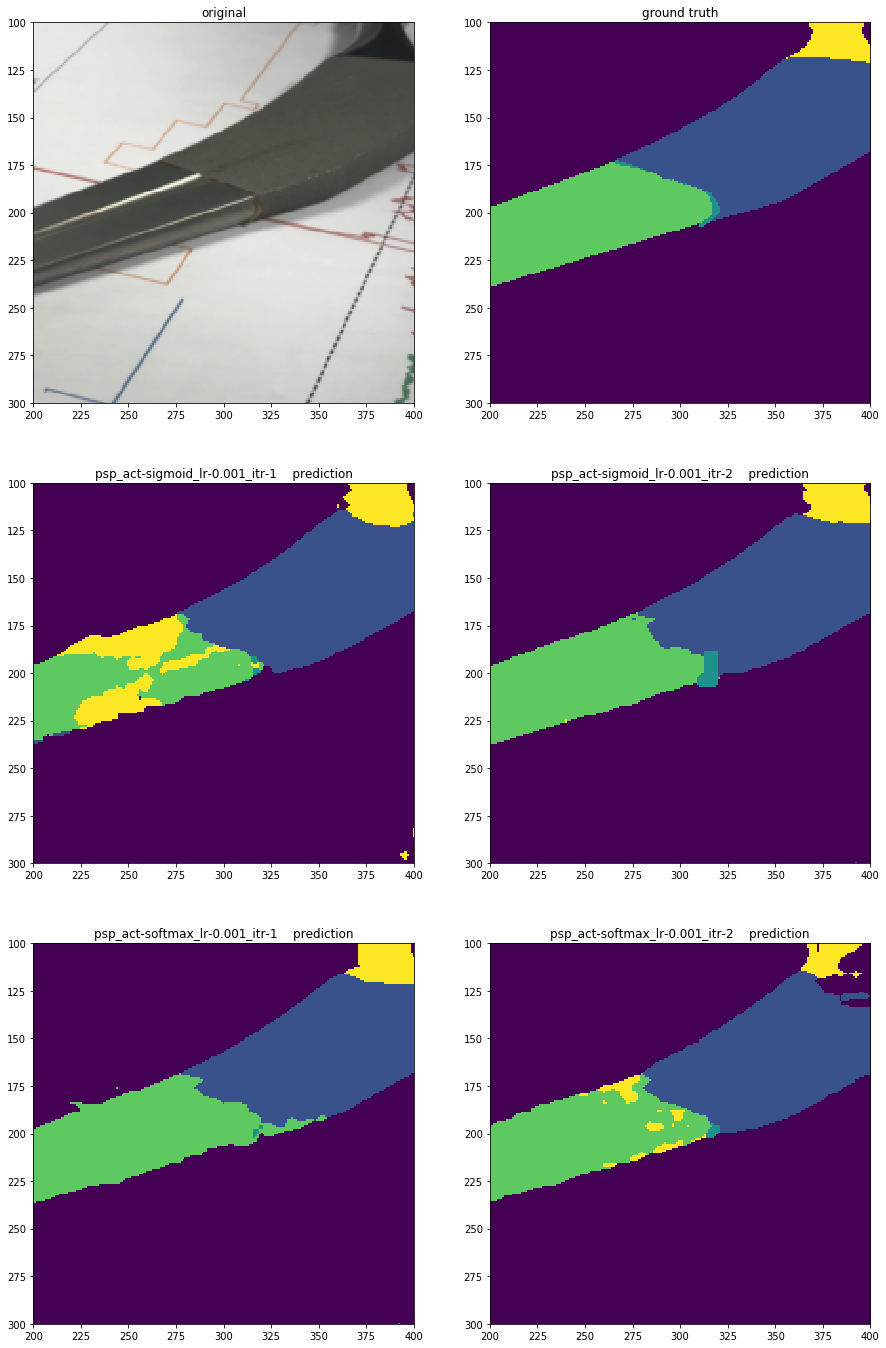

In [25]:
def visual_comparison_combined(models, X_test, y_test, y_pred, test_image=0, xzoom=None, yzoom=None):
    rows = int( (len(models) / 2) + 1.5 )
    plt.figure(figsize=(15, rows * 8))

    plt.subplot(rows, 2, 1)
    plt.imshow(X_test[test_image])
    plt.title('original')
    plt.xlim(xzoom); plt.ylim(yzoom)

    plt.subplot(rows, 2, 2)
    plt.imshow(combine(y_test)[test_image])
    plt.title('ground truth')
    plt.xlim(xzoom); plt.ylim(yzoom)

    for i, y_pred in enumerate(y_preds):
        plt.subplot(rows, 2, 3+i)
        plt.imshow(combine(y_pred)[test_image])
        plt.title(model_names[i] + '    prediction')
        plt.xlim(xzoom); plt.ylim(yzoom)
        

visual_comparison_combined(models, X_test, y_test, y_pred, 0, (200, 400), (300, 100))

### Defect class only

Probability predictions for tape class


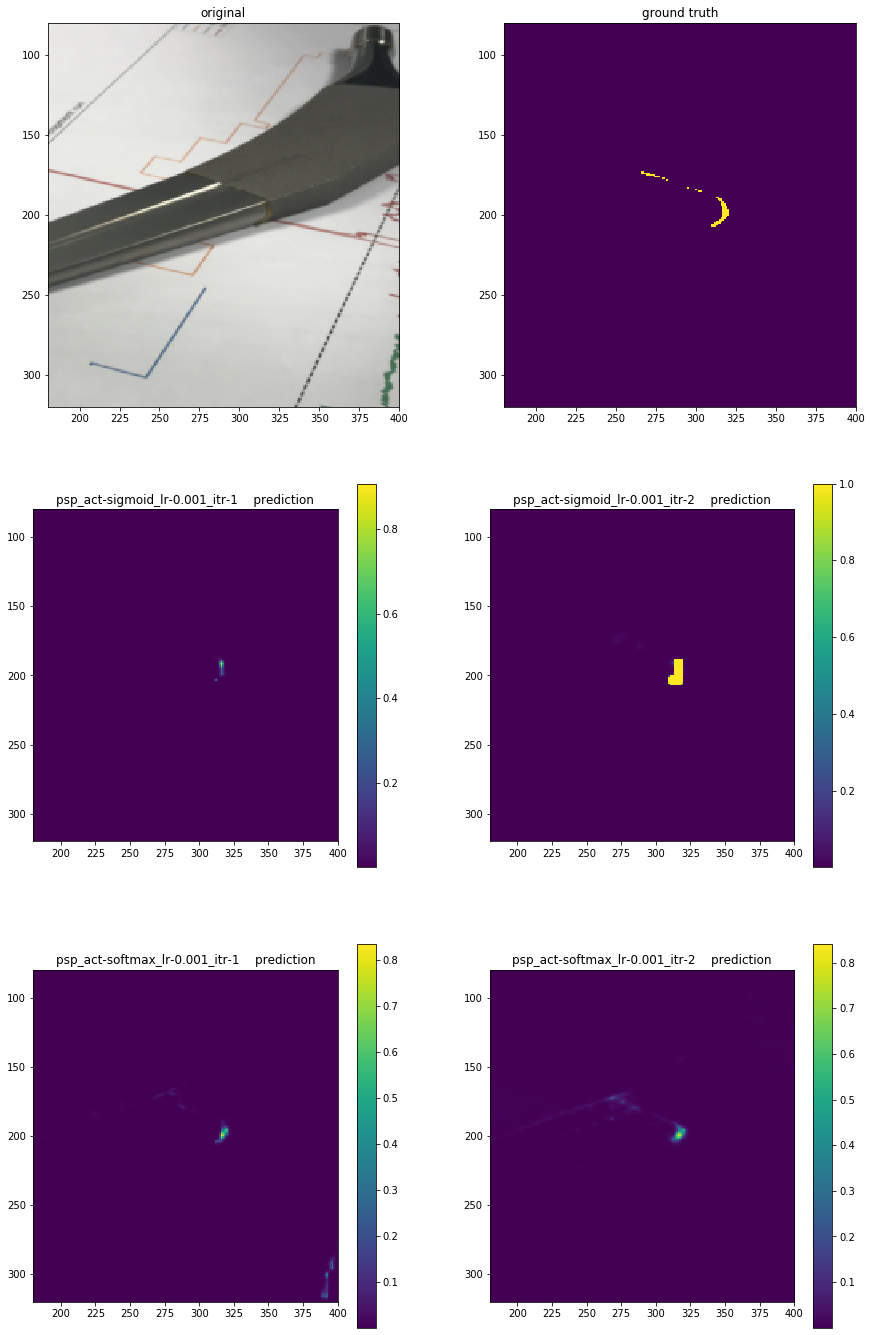

In [127]:
def visual_comparison_channel(defect_class, test_image, classes, models, X_test, y_test, y_pred, model_names,
                              xzoom=None, yzoom=None):
    print(f'Probability predictions for {classes[defect_class]} class')

    rows = int( (len(models) / 2) + 1.5 )
    plt.figure(figsize=(15, rows * 8))

    plt.subplot(rows, 2, 1)
    plt.imshow(X_test[test_image])
    plt.title('original')
    plt.xlim(xzoom); plt.ylim(yzoom)

    plt.subplot(rows, 2, 2)
    plt.imshow(y_test[test_image, :, :, defect_class])
    plt.title('ground truth')
    plt.xlim(xzoom); plt.ylim(yzoom)

    for i, y_pred in enumerate(y_preds):
        plt.subplot(rows, 2, 3+i)
        plt.imshow(y_pred[test_image, :, :, defect_class])
        plt.title(model_names[i] + '    prediction')
        plt.xlim(xzoom); plt.ylim(yzoom)
        plt.colorbar()


args = classes, models, X_test, y_test, y_pred, model_names
visual_comparison_channel(2, 0, *args, (180, 400), (320, 80))

## Metrics
Accuracy, [precission and recall](https://en.wikipedia.org/wiki/Precision_and_recall) for predictions from seperate channels.

Calculate scores:

In [ ]:
def scores(defect_class, threshold, y_test, y_pred):
    accuracies, precisions, recalls = [], [], []
    for y_pred in y_preds:
        y_score, y_pred = y_test[:, :, :, defect_class].ravel(), y_pred[:, :, :, defect_class].ravel() > threshold
        accuracies.append( accuracy_score(y_score, y_pred) )
        precisions.append( precision_score(y_score, y_pred) )
        recalls.append( recall_score(y_score, y_pred) )
    return accuracies, precisions, recalls

### Bar charts

scores for tape, threshold = 0.2


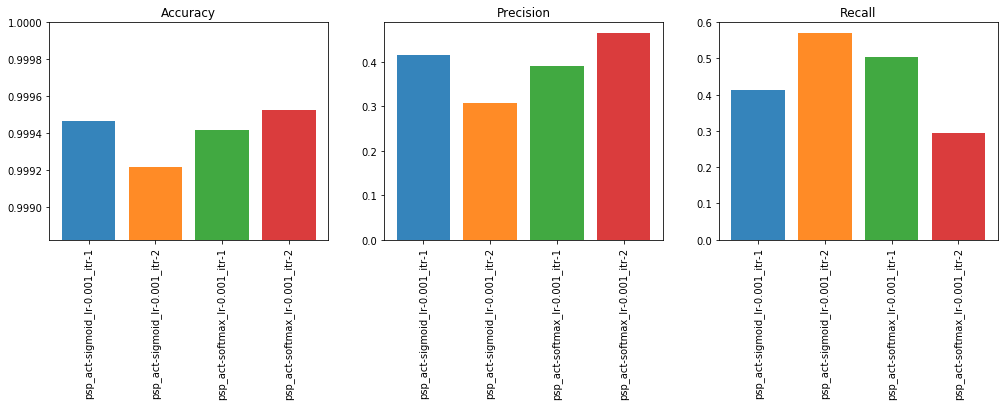

In [108]:
def scores_bar_charts(accuracies, precisions, recalls, model_names, defect_class=None, threshold=None, figsize=(17, 4)):
    acc = np.array(accuracies)
    acc = (acc - acc.min()) / (acc.max() - acc.min())
    if defect_class and threshold:
        print(f'scores for {classes[defect_class]}, threshold = {threshold}')
    plt.figure(figsize=figsize)
    for i, (metric, title) in enumerate(zip([accuracies, precisions, recalls], ['Accuracy', 'Precision', 'Recall'])):
        plt.subplot(1, 3, i+1)
        plt.bar(model_names, metric, color=plt.rcParams['axes.prop_cycle'].by_key()['color'], alpha=0.9)
        plt.title(title)
        plt.xticks(rotation=90)
        if i == 0:
            low = np.array(accuracies).min()
            plt.ylim(low * (1 - ((1 - low) * 0.5)) , 1)

        
accuracies, precisions, recalls = scores(2, 0.1, y_test, y_pred)
scores_bar_charts(accuracies, precisions, recalls, model_names, 2, 0.2)

### Radar plot

In [105]:
def radar_scores(defect_class, threshold, y_test, y_pred, model_names, colors=None):
    accuracies, precisions, recalls = scores(defect_class, threshold, y_test, y_pred)
    labels = ['Accuracy', 'Precision', 'Recall']
    if not colors:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    for acc, presn, rec, color, label in zip(accuracies, precisions, recalls, colors, model_names):
        values = [acc, presn, rec, acc]
        ax.plot(angles, values, label=label, color=color)
        ax.fill(angles, values, color=color, alpha=0.05)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), labels)
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(180)
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    ax.set_title('Model metrics', y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    ax.text(5.5, 1.5, f'threshold = {threshold:.2f}', size=15)

    
def widget_radar_scores(defect_class, threshold):
    defect_class = classes.index(defect_class)
    radar_scores(defect_class, threshold, y_test, y_pred, model_names, ['blue', 'purple', 'red', 'orange'])


interact(widget_radar_scores,
         defect_class=widgets.Dropdown(options=classes, value='tape', desription='class:'),
         threshold=widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, layout=Layout(width='70%')));

interactive(children=(Dropdown(description='defect_class', index=2, options=('background', 'coated surface', '…

A gif of radar charts accross thresholds can be created with the cell below *(note; can take a long time if the number of frames is high)*:

In [109]:
%%time
@gif.frame
def plot(threshold):
    radar_scores(2, threshold, y_test, y_pred, model_names, ['blue', 'purple', 'red', 'orange'])

frames = []
for threshold in np.linspace(0.01, 0.99, 20):
    frames.append( plot(threshold) )

gif.save(frames, 'test.gif', duration=500)

Wall time: 45 s


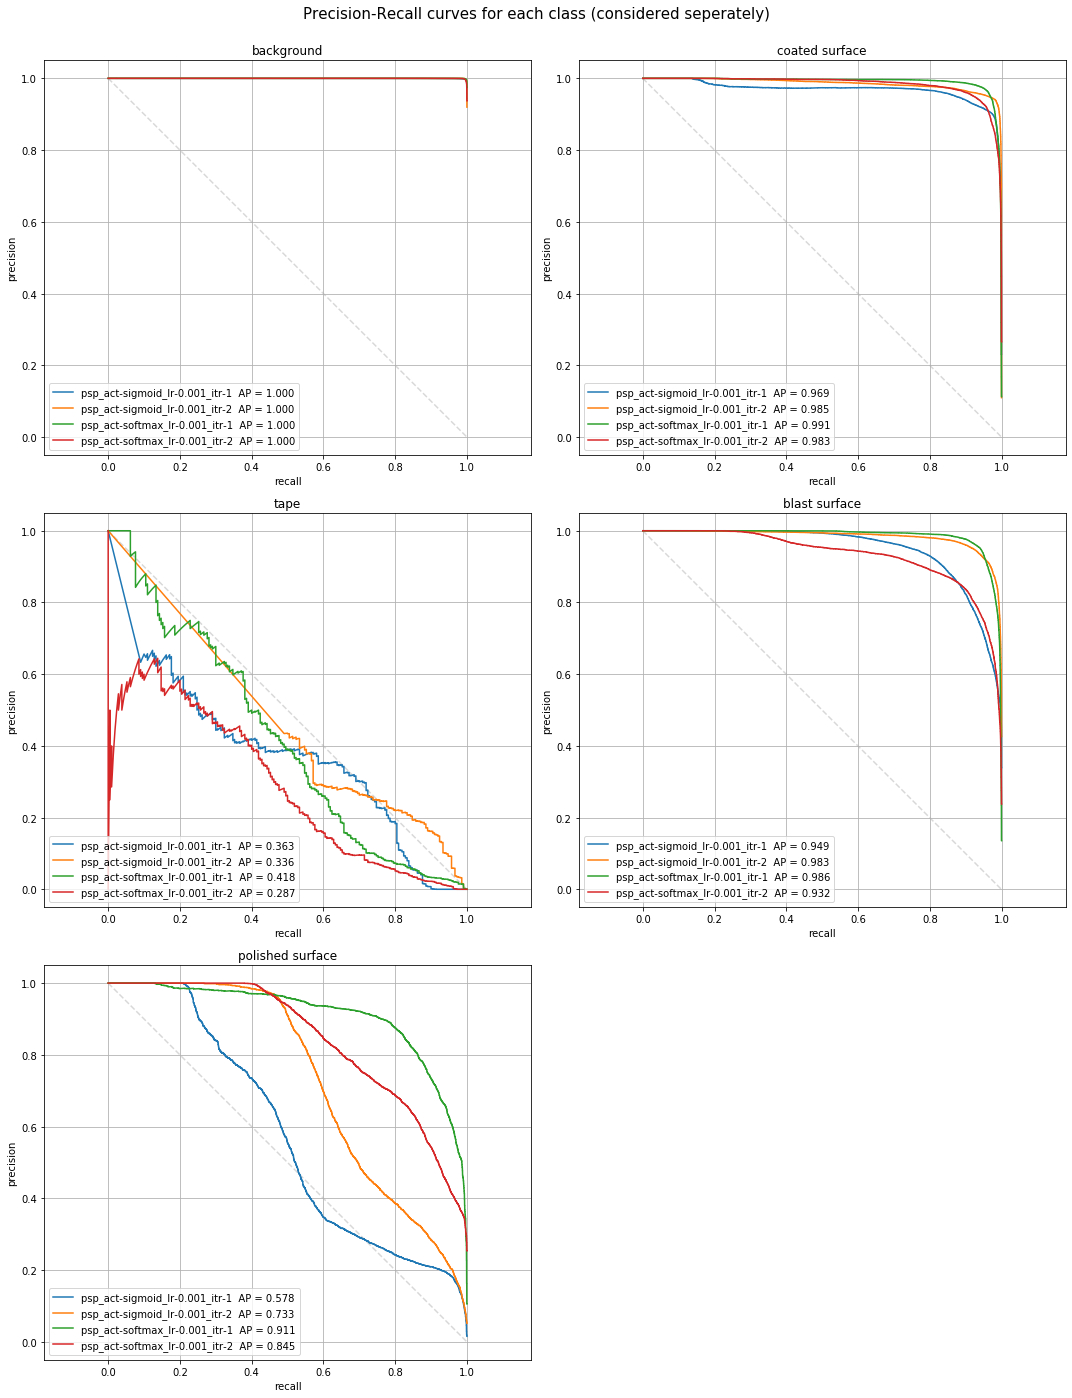

In [179]:
def pr_curve(defect_class, y_test, y_preds, model_names, classes):
    aps = []
    y_test = y_test[:, :, :, defect_class].ravel()
    for model, y_pred in enumerate(y_preds):
        y_score = y_pred[:, :, :, defect_class].ravel()
        ap = average_precision_score(y_test, y_score)
        aps.append(ap)
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        plt.plot(recall, precision, label=f'{model_names[model]}  AP = {ap:.3f}')
    plt.plot([0, 1], [1, 0], ls='--', c='grey', zorder=0, alpha=0.3)
    plt.title(classes[defect_class])
    plt.xlabel('recall'); plt.ylabel('precision')
    plt.axis('equal')
    plt.grid()
    plt.legend(loc='lower left')
    

def pr_curves(classes, y_test, y_preds, model_names):
    rows = int(len(classes) / 2 + 0.5)
    plt.figure(figsize=(15, rows*6 + 1))
    plt.suptitle('Precision-Recall curves for each class (considered seperately)', y=1.02, size=15)
    for channel, cls in enumerate(classes):
        plt.subplot(rows, 2, channel+1)
        pr_curve(channel, y_test, y_preds, model_names, classes)
    plt.tight_layout()
            
        
pr_curves(classes, y_test, y_preds, model_names)